In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import sys
sys.path.append("..")

In [11]:
from util import show, plot_images, plot_tensors

In [12]:
from torchvision import transforms
from torch.utils.data import Dataset
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data
import torchvision
from torchvision import transforms
from skimage.measure import compare_psnr

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


EPOCHS = 2
BATCH_SIZE = 20
LEARNING_RATE = 0.003
TRAIN_DATA_PATH = "./Confocal_BPAE_B/raw"
GT_DATA_PATH = "./Confocal_BPAE_B/gt"
TRANSFORM_IMG = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
    
    ])
train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
gt_data = torchvision.datasets.ImageFolder(root=GT_DATA_PATH, transform=TRANSFORM_IMG)


In [13]:
dataset1 = train_data
dataset2 = gt_data


class gtmatch(Dataset):
    def __init__(self, dataset1, dataset2, batch_size):
        self.dataset1 = dataset1
        self.dataset2 = dataset2
        
    def __getitem__(self, index):
        x = self.dataset1[index][0]
        y= self.dataset2[int(index/batch_size % batch_size)][0]
        return x, y
    
    def __len__(self):
        return len(self.dataset1)

newdataset = gtmatch(dataset1, dataset2, 50)

In [75]:
batch_size=50
from torch import randn
def add_noise(img):
    return img + randn(img.size())*0.2

class SyntheticNoiseDataset(Dataset):
    def __init__(self, data, mode='train'):
        self.mode = mode
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img = self.data[index][0]
        return add_noise(img), img



In [76]:
newdataset = SyntheticNoiseDataset(newdataset, 'train')

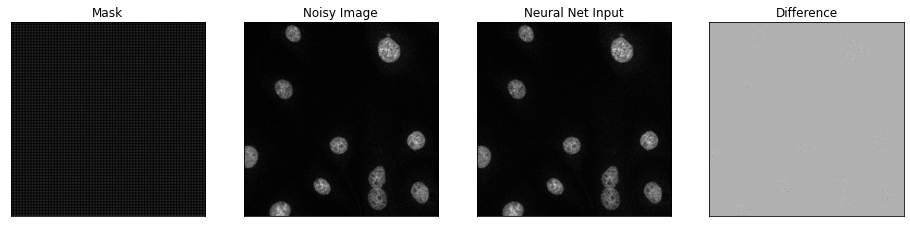

In [77]:
from mask import Masker
masker = Masker(width = 4, mode='interpolate')
net_input, mask = masker.mask(noisy, 3)
plot_tensors([mask, noisy[0], net_input[0], net_input[0] - noisy[0]],
            ["Mask", "Noisy Image", "Neural Net Input", "Difference"])

In [18]:
from models.RIM import RIM
model = RIM()
model2=RIM()

In [19]:
from torch.nn import MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader
import logging 
loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [44]:
from torch.utils.data.sampler import SequentialSampler
validation_split = .2
shuffle_dataset = False
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(newdataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SequentialSampler(train_indices)
valid_sampler = SequentialSampler(val_indices)

train_loader = torch.utils.data.DataLoader(newdataset, batch_size=batch_size,sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(newdataset, batch_size=batch_size,
                                                sampler=valid_sampler)



In [50]:
from mask import Masker

data_loader = train_loader

#noisy, clean = noisy_data_train[0];
#net_input, mask = masker.mask(noisy.unsqueeze(0), 0);

losses = []
val_losses = []
best_images = []
best_val_loss = 1



for i, batch in enumerate(data_loader):
    print(i)
    noisy_images, clean_images = batch
        
    model.train()
 
    net_input, mask = masker.mask(noisy_images, i)
    #net_input = noisy_images
    


    net_output, hidden = model(net_input)

        
    loss = loss_function(net_output*mask, noisy_images*mask)
    #loss = loss_function(net_output, noisy_images)
    
    optimizer.zero_grad()
 
    loss.backward()
    
    optimizer.step()

    losses.append(loss.item())
    model.eval()
    

    net_input, mask = masker.mask(noisy_images, masker.n_masks - 1)

    #net_input = noisy_images

    net_output, hidden = model(net_input)


    val_loss = loss_function(net_output*mask, noisy_images*mask)
    #val_loss = net_output

    val_losses.append(val_loss.item())



    print("Loss (", i, "): \t", round(loss.item(), 4))
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        #denoised = np.clip(model(noisy_images[0]).detach().cpu().numpy()[0, 0], 0, 1).astype(np.float64)
        #clean=np.clip(clean_images.detach().cpu().numpy()[0, 0], 0, 1).astype(np.float64)
        #best_psnr = compare_psnr(denoised, clean)
        #best_images.append(denoised)
        #print("\tModel PSNR: ", np.round(best_psnr, 2))



0


/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Loss ( 0 ): 	 0.0003
1
Loss ( 1 ): 	 0.0005
2
Loss ( 2 ): 	 0.0005
3
Loss ( 3 ): 	 0.0003
4
Loss ( 4 ): 	 0.0003
5
Loss ( 5 ): 	 0.0003
6
Loss ( 6 ): 	 0.0006
7
Loss ( 7 ): 	 0.0004
8
Loss ( 8 ): 	 0.0005
9
Loss ( 9 ): 	 0.0002
10
Loss ( 10 ): 	 0.0006
11
Loss ( 11 ): 	 0.0002
12
Loss ( 12 ): 	 0.0004
13
Loss ( 13 ): 	 0.0003
14
Loss ( 14 ): 	 0.0003
15
Loss ( 15 ): 	 0.0004


In [54]:

i, test_batch = next(enumerate(validation_loader))
noisy, clean = test_batch

In [55]:
from mask import Masker

simple_output = model(noisy)
invariant_output = masker.infer_full_image(noisy, model)

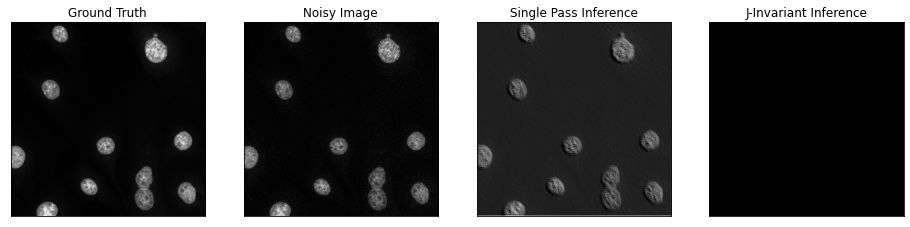

In [78]:
idx = 46
plot_tensors([clean[idx], noisy[idx], simple_output[1][idx], invariant_output[idx]],
            ["Ground Truth", "Noisy Image", "Single Pass Inference", "J-Invariant Inference"])

In [57]:
print("Test loss, single pass: ", round(loss_function(clean, simple_output[0]).item(), 3))
print("Test loss, J-invariant: ", round(loss_function(clean, invariant_output).item(), 3))

Test loss, single pass:  0.004
Test loss, J-invariant:  0.004
